<h1> Loading Libraries and necessary packages</h1>

In [13]:
import numpy as np   #library required for matrix calculations
import pandas as pd  #used to treat data as a dataframe
import re            #library used for regular expressions
import xgboost as xb #boosting algorithm 
import matplotlib.pyplot as plt #library required for data visualization
%matplotlib inline   
plt.style.use('seaborn') #another visualization library
import seaborn as sns #importing for viewing data visualizations
from geopy.distance import great_circle #library used to calculate the distance
from geopy.distance import vincenty #Library used to calculate the distance by points
from collections import Counter #function used for counting the values

In [14]:
dataframe_listings = pd.read_csv('listings_summary.csv') #importing listings as a dataframe

In [15]:
dataframe_listings.shape   #checking rows and columns in dataframe

(22552, 96)

In [16]:
dataframe_listings.head() #viewing listings from the dataframe

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


In [17]:
dataframe_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
id                                  22552 non-null int64
listing_url                         22552 non-null object
scrape_id                           22552 non-null int64
last_scraped                        22552 non-null object
name                                22493 non-null object
summary                             21589 non-null object
space                               14020 non-null object
description                         22349 non-null object
experiences_offered                 22552 non-null object
neighborhood_overview               11540 non-null object
notes                               7215 non-null object
transit                             13036 non-null object
access                              10837 non-null object
interaction                         10406 non-null object
house_rules                         11449 non-null object
thumbnail_url           

In [18]:
dataframe_listings.duplicated().sum()  #checking for duplicates present in whole dataset

0

In [19]:
dataframe_listings.columns #printing the names of the columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

<h1> Data Cleaning and Preprocessing</h1>

<h2> Selecting Relevant Columns </h2>

In [20]:
##selecting the useful columns out of the dataset 
relevant_columns = ['id','room_type','neighbourhood_group_cleansed','accommodates', 'bathrooms', 'description',
                    'latitude','longitude', 'property_type', 'space',  'host_has_profile_pic', 'bedrooms',
                    'extra_people', 'guests_included','minimum_nights','is_business_travel_ready', 'cleaning_fee', 
                   'security_deposit','bed_type', 'amenities', 'square_feet', 'price',
                   'instant_bookable', 'cancellation_policy','review_scores_accuracy','number_of_reviews']

In [21]:
relevant_dataframe = dataframe_listings[relevant_columns].set_index('id') #setting the index of the dataset

In [22]:
relevant_dataframe.neighbourhood_group_cleansed.unique()

array(['Mitte', 'Pankow', 'Tempelhof - Schöneberg',
       'Friedrichshain-Kreuzberg', 'Neukölln', 'Charlottenburg-Wilm.',
       'Treptow - Köpenick', 'Steglitz - Zehlendorf', 'Reinickendorf',
       'Lichtenberg', 'Marzahn - Hellersdorf', 'Spandau'], dtype=object)

In [23]:
relevant_dataframe.head() #checking sample of dataset

,room_type,neighbourhood_group_cleansed,accommodates,bathrooms,description,latitude,longitude,property_type,space,host_has_profile_pic,...,cleaning_fee,security_deposit,bed_type,amenities,square_feet,price,instant_bookable,cancellation_policy,review_scores_accuracy,number_of_reviews
id,,,,,,,,,,,,,,,,,,,,,
2015,Entire home/apt,Mitte,3,1.0,Great location! 30 of 75 sq meters. This wood...,52.534537,13.402557,Guesthouse,A+++ location! This „Einliegerwohnung“ is an e...,t,...,$30.00,$200.00,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,f,strict_14_with_grace_period,10.0,118
2695,Private room,Pankow,2,1.0,In the summertime we are spending most of our ...,52.548513,13.404553,Apartment,In the summertime we are spending most of our ...,t,...,$0.00,$0.00,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",NaN,$17.00,f,flexible,10.0,6
3176,Entire home/apt,Pankow,4,1.0,This beautiful first floor apartment is situa...,52.534996,13.417579,Apartment,1st floor (68m2) apartment on Kollwitzplatz/ P...,t,...,$50.00,$200.00,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",720.0,$90.00,t,strict_14_with_grace_period,9.0,143
3309,Private room,Tempelhof - Schöneberg,2,1.0,First of all: I prefer short-notice bookings. ...,52.498855,13.349065,Apartment,"Your room is really big and has 26 sqm, is ver...",t,...,$30.00,$250.00,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",0.0,$26.00,f,strict_14_with_grace_period,9.0,25
7071,Private room,Pankow,2,1.0,Cozy and large room in the beautiful district ...,52.543157,13.415091,Apartment,"The BrightRoom is an approx. 20 sqm (215ft²), ...",t,...,$0.00,$0.00,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",NaN,$42.00,f,moderate,10.0,197


In [24]:
relevant_dataframe.shape

(22552, 25)

In [25]:
check_property_type=relevant_dataframe['property_type'].value_counts(normalize=True)

In [26]:
#checking property and its listings
check_property_type.sort_values(ascending=True)  #checking the property types in listings

In-law                    0.000044
Island                    0.000044
Cave                      0.000044
Chalet                    0.000044
Tipi                      0.000044
Barn                      0.000044
Casa particular (Cuba)    0.000089
Castle                    0.000089
Train                     0.000089
Resort                    0.000133
Cottage                   0.000177
Cabin                     0.000266
Aparthotel                0.000310
Pension (South Korea)     0.000310
Villa                     0.000443
Camper/RV                 0.000488
Houseboat                 0.000488
Tiny house                0.000532
Boat                      0.000754
Bungalow                  0.000887
Boutique hotel            0.001907
Other                     0.002084
Hotel                     0.002217
Guesthouse                0.002527
Bed and breakfast         0.002838
Guest suite               0.003281
Townhouse                 0.004390
Hostel                    0.005676
Serviced apartment  

In [27]:
check_room_type=relevant_dataframe['room_type'].value_counts(normalize=True)

In [28]:
check_room_type.sort_values(ascending=True) 

Shared room        0.013125
Entire home/apt    0.475435
Private room       0.511440
Name: room_type, dtype: float64

<h2> Checking all types of pricings</h2>

In [29]:
dataframe_pricings=relevant_dataframe[['security_deposit', 'extra_people','cleaning_fee', 'price' ]] #combining all types of pricing listings

In [30]:
dataframe_pricings.head() #checking for all types of pricings listings

,security_deposit,extra_people,cleaning_fee,price
id,,,,
2015,$200.00,$28.00,$30.00,$60.00
2695,$0.00,$0.00,$0.00,$17.00
3176,$200.00,$20.00,$50.00,$90.00
3309,$250.00,$18.00,$30.00,$26.00
7071,$0.00,$24.00,$0.00,$42.00


In [31]:
relevant_dataframe[['cleaning_fee']].isnull().sum() #checking null values for cleaning fee

cleaning_fee    7146
dtype: int64

In [32]:
relevant_dataframe['cleaning_fee'].fillna('$0.00', inplace=True)#imputing null values with 0
relevant_dataframe['cleaning_fee'].isnull().sum()#checking null values in cleaning fee

0

In [33]:
relevant_dataframe[['security_deposit']].isnull().sum()#checking null values for security deposit

security_deposit    9361
dtype: int64

In [34]:
relevant_dataframe['security_deposit'].fillna('$0.00', inplace=True) #imputing null values with 0
relevant_dataframe['security_deposit'].isnull().sum() #checking null values in security deposit after imputing

0

In [35]:
relevant_dataframe['extra_people'].isnull().sum() #checking null values in extra people column

0

In [36]:
relevant_dataframe[['price']].isnull().sum() #checking null values in price column

price    0
dtype: int64

In [37]:
# cleaning the columns containing all sort of prices
relevant_dataframe.cleaning_fee = relevant_dataframe.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
relevant_dataframe.security_deposit = relevant_dataframe.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
relevant_dataframe.extra_people = relevant_dataframe.extra_people.str.replace('$', '').str.replace(',', '').astype(float)
relevant_dataframe.price = relevant_dataframe.price.str.replace('$', '').str.replace(',', '').astype(float)

In [38]:
relevant_dataframe['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

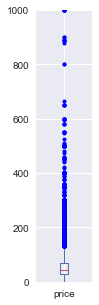

In [39]:
blue_color = dict(markerfacecolor='b', markeredgecolor='b', marker='.')  ## to manipulate and chamge the code
relevant_dataframe['price'].plot(kind='box', ylim=(0, 1000), vert=True, flierprops=blue_color, figsize=(1,5))

In [40]:
relevant_dataframe.drop(relevant_dataframe[(relevant_dataframe.price > 500) | (relevant_dataframe.price == 0) ].index, axis=0, inplace=True)

In [41]:
relevant_dataframe['price'].describe()

count    22470.000000
mean        58.117980
std         44.687913
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        500.000000
Name: price, dtype: float64

In [42]:
relevant_dataframe.shape

(22470, 25)

In [43]:
relevant_dataframe.isnull().sum()

room_type                           0
neighbourhood_group_cleansed        0
accommodates                        0
bathrooms                          32
description                       202
latitude                            0
longitude                           0
property_type                       0
space                            8515
host_has_profile_pic               25
bedrooms                           18
extra_people                        0
guests_included                     0
minimum_nights                      0
is_business_travel_ready            0
cleaning_fee                        0
security_deposit                    0
bed_type                            0
amenities                           0
square_feet                     22024
price                               0
instant_bookable                    0
cancellation_policy                 0
review_scores_accuracy           4372
number_of_reviews                   0
dtype: int64

In [44]:
relevant_dataframe.drop(['space', 'square_feet'], inplace=True, axis=1)

In [45]:
relevant_dataframe.dropna(subset=['bedrooms', 'bathrooms','review_scores_accuracy' ], inplace=True)

In [46]:
#relevant_dataframe.dropna(subset=['review_scores_rating'], inplace=True)

In [47]:
relevant_dataframe.host_has_profile_pic.unique().tolist()

['t', nan, 'f']

In [48]:
relevant_dataframe.host_has_profile_pic.fillna(value='f', inplace=True)

In [49]:
relevant_dataframe.host_has_profile_pic.unique().tolist()

['t', 'f']

In [50]:
relevant_dataframe.shape

(18064, 23)

In [51]:
relevant_dataframe.isnull().sum()

room_type                         0
neighbourhood_group_cleansed      0
accommodates                      0
bathrooms                         0
description                     128
latitude                          0
longitude                         0
property_type                     0
host_has_profile_pic              0
bedrooms                          0
extra_people                      0
guests_included                   0
minimum_nights                    0
is_business_travel_ready          0
cleaning_fee                      0
security_deposit                  0
bed_type                          0
amenities                         0
price                             0
instant_bookable                  0
cancellation_policy               0
review_scores_accuracy            0
number_of_reviews                 0
dtype: int64

<h1> Feature Engineering </h1>

<h3> Calculating Distance </h3>

In [52]:
def distance_to_mid_berlin(latitude_point, longitude_point):
    center_of_berlin = (52.520008, 13.404954)
    accommodation_points = (latitude_point, longitude_point)
    return vincenty(center_of_berlin, accommodation_points).km

In [53]:
relevant_dataframe['distance_from_center'] = relevant_dataframe.apply(lambda x: distance_to_mid_berlin(x.latitude, x.longitude), axis=1)

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  after removing the cwd from sys.path.


In [54]:
relevant_dataframe.head()

,room_type,neighbourhood_group_cleansed,accommodates,bathrooms,description,latitude,longitude,property_type,host_has_profile_pic,bedrooms,...,cleaning_fee,security_deposit,bed_type,amenities,price,instant_bookable,cancellation_policy,review_scores_accuracy,number_of_reviews,distance_from_center
id,,,,,,,,,,,,,,,,,,,,,
2015,Entire home/apt,Mitte,3,1.0,Great location! 30 of 75 sq meters. This wood...,52.534537,13.402557,Guesthouse,t,1.0,...,30.0,200.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",60.0,f,strict_14_with_grace_period,10.0,118,1.624949
2695,Private room,Pankow,2,1.0,In the summertime we are spending most of our ...,52.548513,13.404553,Apartment,t,1.0,...,0.0,0.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",17.0,f,flexible,10.0,6,3.172058
3176,Entire home/apt,Pankow,4,1.0,This beautiful first floor apartment is situa...,52.534996,13.417579,Apartment,t,1.0,...,50.0,200.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",90.0,t,strict_14_with_grace_period,9.0,143,1.875055
3309,Private room,Tempelhof - Schöneberg,2,1.0,First of all: I prefer short-notice bookings. ...,52.498855,13.349065,Apartment,t,1.0,...,30.0,250.0,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",26.0,f,strict_14_with_grace_period,9.0,25,4.465424
7071,Private room,Pankow,2,1.0,Cozy and large room in the beautiful district ...,52.543157,13.415091,Apartment,t,1.0,...,0.0,0.0,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",42.0,f,moderate,10.0,197,2.666263


<h1> Calculating Size of the location </h1>

In [55]:
relevant_dataframe['description'].isna().sum()

128

In [56]:
relevant_dataframe['size_of_location'] = relevant_dataframe['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
relevant_dataframe['size_of_location'] = relevant_dataframe['size_of_location'].str.replace("\D", "")

relevant_dataframe['size_of_location'] = relevant_dataframe['size_of_location'].astype(float)

In [57]:
relevant_dataframe['size_of_location'].isna().sum()

9135

In [58]:
round(relevant_dataframe['size_of_location'].isna().sum()/len(relevant_dataframe),2)

0.51

In [59]:
relevant_dataframe.drop(['description'], axis=1, inplace=True)

<h2> Predicting Missing Values of Size attribute </h2>

In [60]:
relevant_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18064 entries, 2015 to 29740105
Data columns (total 24 columns):
room_type                       18064 non-null object
neighbourhood_group_cleansed    18064 non-null object
accommodates                    18064 non-null int64
bathrooms                       18064 non-null float64
latitude                        18064 non-null float64
longitude                       18064 non-null float64
property_type                   18064 non-null object
host_has_profile_pic            18064 non-null object
bedrooms                        18064 non-null float64
extra_people                    18064 non-null float64
guests_included                 18064 non-null int64
minimum_nights                  18064 non-null int64
is_business_travel_ready        18064 non-null object
cleaning_fee                    18064 non-null float64
security_deposit                18064 non-null float64
bed_type                        18064 non-null object
amenities        

In [61]:
reduced_dataframe = relevant_dataframe[['size_of_location','distance_from_center','security_deposit','guests_included',  
                                        'cleaning_fee', 'price', 
                                         'extra_people', 'bedrooms', 'accommodates', 'bathrooms']]

In [62]:
size_train_data = reduced_dataframe[reduced_dataframe['size_of_location'].notnull()]
size_test_data  = reduced_dataframe[reduced_dataframe['size_of_location'].isnull()]

In [63]:
size_X_train = size_train_data.drop('size_of_location', axis=1)
size_X_test  = size_test_data.drop('size_of_location', axis=1)

In [64]:
size_y_train = size_train_data['size_of_location']

In [65]:
size_train_data.shape

(8929, 10)

In [66]:
size_test_data.shape

(9135, 10)

In [67]:
size_X_train.shape

(8929, 9)

In [68]:
size_X_test.shape

(9135, 9)

In [69]:
size_y_train.shape

(8929,)

In [70]:
size_X_test_copy=size_X_test

In [71]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression()

lreg.fit(size_X_train, size_y_train)
y_test_size_output = lreg.predict(size_X_test)

In [72]:
y_test_size_output = pd.DataFrame(y_test_size_output)
y_test_size_output.columns = ['size_of_location']

In [73]:
y_test_size_output.head(10)

,size_of_location
0,58.495580
1,96.688950
2,77.024951
3,87.224892
4,67.901160
5,54.745429
6,64.840779
7,52.796577
8,44.906953
9,83.344460


In [74]:
size_initial_index = pd.DataFrame(size_X_test.index)
size_initial_index.columns = ['size_initials']


y_test_size_output = pd.concat([y_test_size_output, size_initial_index], axis=1)
y_test_size_output.set_index(['size_initials'], inplace=True)
y_test_size_output.head(10)

,size_of_location
size_initials,
14325,58.495580
20858,96.688950
21869,77.024951
22415,87.224892
28156,67.901160
31440,54.745429
38296,64.840779
41217,52.796577
41306,44.906953


In [75]:
y_test_size_output.shape

(9135, 1)

In [76]:
size_X_test.shape

(9135, 9)

In [77]:
size_X_test.head(10)

,distance_from_center,security_deposit,guests_included,cleaning_fee,price,extra_people,bedrooms,accommodates,bathrooms
id,,,,,,,,,
14325,3.098063,500.0,1,0.0,70.0,0.0,0.0,2,1.0
20858,1.894161,500.0,2,49.0,129.0,24.0,2.0,4,1.0
21869,2.784191,500.0,2,40.0,70.0,18.0,1.0,4,1.0
22415,3.223812,300.0,2,50.0,98.0,25.0,2.0,4,1.0
28156,2.972394,1660.0,1,0.0,70.0,0.0,0.0,2,1.0
31440,2.829667,100.0,1,15.0,44.0,15.0,1.0,1,1.0
38296,4.005418,500.0,2,35.0,80.0,0.0,1.0,2,1.0
41217,1.891995,0.0,1,0.0,43.0,13.0,1.0,2,1.0
41306,1.699220,0.0,1,0.0,40.0,0.0,1.0,2,1.0


In [78]:
try_test_data = pd.concat([size_X_test, y_test_size_output], axis=1)
try_test_data.shape

(9135, 10)

In [79]:
try_test_data.head()

,distance_from_center,security_deposit,guests_included,cleaning_fee,price,extra_people,bedrooms,accommodates,bathrooms,size_of_location
14325,3.098063,500.0,1,0.0,70.0,0.0,0.0,2,1.0,58.495580
20858,1.894161,500.0,2,49.0,129.0,24.0,2.0,4,1.0,96.688950
21869,2.784191,500.0,2,40.0,70.0,18.0,1.0,4,1.0,77.024951
22415,3.223812,300.0,2,50.0,98.0,25.0,2.0,4,1.0,87.224892
28156,2.972394,1660.0,1,0.0,70.0,0.0,0.0,2,1.0,67.901160


In [80]:
reduced_new_dataset = pd.concat([try_test_data, size_train_data], axis=0)

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [81]:
reduced_new_dataset.shape

(18064, 10)

In [82]:
reduced_new_dataset.head(10)

,accommodates,bathrooms,bedrooms,cleaning_fee,distance_from_center,extra_people,guests_included,price,security_deposit,size_of_location
14325,2,1.0,0.0,0.0,3.098063,0.0,1,70.0,500.0,58.495580
20858,4,1.0,2.0,49.0,1.894161,24.0,2,129.0,500.0,96.688950
21869,4,1.0,1.0,40.0,2.784191,18.0,2,70.0,500.0,77.024951
22415,4,1.0,2.0,50.0,3.223812,25.0,2,98.0,300.0,87.224892
28156,2,1.0,0.0,0.0,2.972394,0.0,1,70.0,1660.0,67.901160
31440,1,1.0,1.0,15.0,2.829667,15.0,1,44.0,100.0,54.745429
38296,2,1.0,1.0,35.0,4.005418,0.0,2,80.0,500.0,64.840779
41217,2,1.0,1.0,0.0,1.891995,13.0,1,43.0,0.0,52.796577
41306,2,1.0,1.0,0.0,1.699220,0.0,1,40.0,0.0,44.906953
43123,4,1.0,1.0,50.0,2.180805,20.0,2,90.0,300.0,83.344460


In [83]:
reduced_new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18064 entries, 14325 to 29721020
Data columns (total 10 columns):
accommodates            18064 non-null int64
bathrooms               18064 non-null float64
bedrooms                18064 non-null float64
cleaning_fee            18064 non-null float64
distance_from_center    18064 non-null float64
extra_people            18064 non-null float64
guests_included         18064 non-null int64
price                   18064 non-null float64
security_deposit        18064 non-null float64
size_of_location        18064 non-null float64
dtypes: float64(8), int64(2)
memory usage: 1.5 MB


In [84]:
relevant_dataframe.drop(['bathrooms','accommodates', 'price', 'bedrooms', 'security_deposit', 'cleaning_fee', 
             'guests_included', 'extra_people', 'size_of_location', 'distance_from_center'], axis=1, inplace=True)

In [85]:
new_dataframe = pd.concat([relevant_dataframe, reduced_new_dataset], axis=1)
new_dataframe.shape

(18064, 24)

<h1> Checking for Amenities </h1>

In [86]:
new_dataframe['amenities']

2015        {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...
2695        {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...
3176        {Internet,Wifi,Kitchen,"Buzzer/wireless interc...
3309        {Internet,Wifi,"Pets allowed","Pets live on th...
7071        {Wifi,Heating,"Family/kid friendly",Essentials...
                                  ...                        
29671651    {Wifi,"Air conditioning",Kitchen,"Smoking allo...
29680856    {Wifi,Kitchen,Breakfast,Heating,Washer,"First ...
29710765    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
29721020    {TV,"Cable TV",Kitchen,"Free street parking","...
29740105    {TV,Wifi,Kitchen,"Smoking allowed",Elevator,He...
Name: amenities, Length: 18064, dtype: object

In [87]:
amenities_count = Counter()
new_dataframe['amenities'].str.strip('{}').str.replace('"', '').str.lstrip('\"').str.rstrip('\"').str.split(',')\
               .apply(amenities_count.update)

amenities_count.most_common(20)

[('Wifi', 17392),
 ('Heating', 17140),
 ('Kitchen', 17131),
 ('Essentials', 16656),
 ('Washer', 14847),
 ('Hair dryer', 12573),
 ('Laptop friendly workspace', 11977),
 ('Hangers', 11580),
 ('Iron', 9380),
 ('Shampoo', 8986),
 ('Hot water', 8902),
 ('TV', 8146),
 ('Family/kid friendly', 6945),
 ('Internet', 6591),
 ('Host greets you', 6166),
 ('Smoke detector', 5345),
 ('Buzzer/wireless intercom', 5086),
 ('Free street parking', 4889),
 ('Refrigerator', 4819),
 ('Dishes and silverware', 4702)]

In [88]:
amenities_df = pd.DataFrame(amenities_count.most_common(20), columns=['amenity', 'count_of_amenities'])

In [89]:
amenities_df.head(10)

,amenity,count_of_amenities
0,Wifi,17392
1,Heating,17140
2,Kitchen,17131
3,Essentials,16656
4,Washer,14847
5,Hair dryer,12573
6,Laptop friendly workspace,11977
7,Hangers,11580
8,Iron,9380
9,Shampoo,8986


In [90]:
new_dataframe['TV'] = new_dataframe['amenities'].str.contains('TV')#Categorical features whether it has TV
new_dataframe['Family_kid_friendly'] = new_dataframe['amenities'].str.contains('Family/kid friendly')#Categorical features whether it is kid friendly
new_dataframe['Laptop_friendly_workspace'] = new_dataframe['amenities'].str.contains('Laptop friendly workspace') #categorical features formulated
new_dataframe['Smoking_allowed'] = new_dataframe['amenities'].str.contains('Smoking allowed')#Categorical feature whether smoking is allowed
new_dataframe['Host_greets_you'] = new_dataframe['amenities'].str.contains('Host greets you')#Categorical feature whether guest is greeted

In [91]:
new_dataframe.head()#dataframe after building categorical features

,room_type,neighbourhood_group_cleansed,latitude,longitude,property_type,host_has_profile_pic,minimum_nights,is_business_travel_ready,bed_type,amenities,...,extra_people,guests_included,price,security_deposit,size_of_location,TV,Family_kid_friendly,Laptop_friendly_workspace,Smoking_allowed,Host_greets_you
2015,Entire home/apt,Mitte,52.534537,13.402557,Guesthouse,t,4,f,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",...,28.0,1,60.0,200.0,75.0,True,True,True,False,False
2695,Private room,Pankow,52.548513,13.404553,Apartment,t,2,f,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",...,0.0,1,17.0,0.0,25.0,False,False,True,False,False
3176,Entire home/apt,Pankow,52.534996,13.417579,Apartment,t,62,f,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",...,20.0,2,90.0,200.0,68.0,False,True,True,False,False
3309,Private room,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,t,5,f,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",...,18.0,1,26.0,250.0,26.0,False,False,True,False,True
7071,Private room,Pankow,52.543157,13.415091,Apartment,t,2,f,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",...,24.0,1,42.0,0.0,20.0,False,True,True,False,False


<h1> Exploratory Data Analysis</h1>

In [92]:
list_of_neighbourbood_groups = dataframe_listings[[ 'room_type','neighbourhood_group_cleansed']]
two_classes = pd.crosstab(list_of_neighbourbood_groups.room_type,list_of_neighbourbood_groups.neighbourhood_group_cleansed)
two_classes

neighbourhood_group_cleansed,Charlottenburg-Wilm.,Friedrichshain-Kreuzberg,Lichtenberg,Marzahn - Hellersdorf,Mitte,Neukölln,Pankow,Reinickendorf,Spandau,Steglitz - Zehlendorf,Tempelhof - Schöneberg,Treptow - Köpenick
room_type,,,,,,,,,,,,
Entire home/apt,848,2475,293,80,2236,1376,1988,115,72,224,717,298
Private room,719,2967,383,56,2288,2099,1523,128,48,211,819,293
Shared room,25,55,12,5,107,24,30,4,4,2,24,4


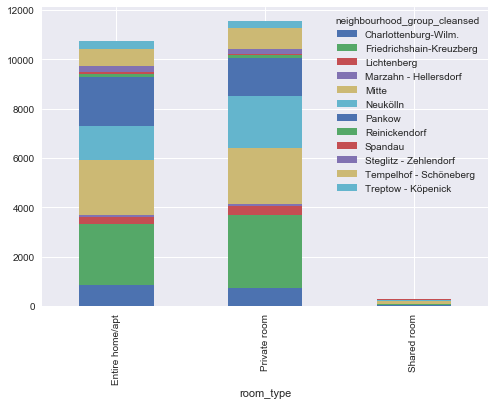

In [93]:
two_classes.plot.bar(stacked=True)
plt.show()

<h2> Latitude and Longitude Linking with Price</h2>

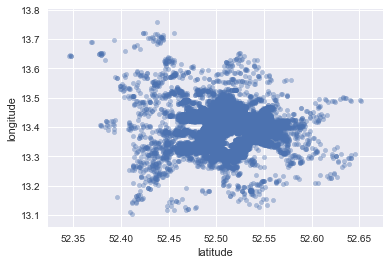

In [110]:
dataframe_listings.plot(kind="scatter", x="latitude", y="longitude", alpha=0.4, figsize=(6,4), cmap="gist_heat_r", colorbar=False, sharex=False);

<h2> Price Difference by number of Bedrooms</h2>

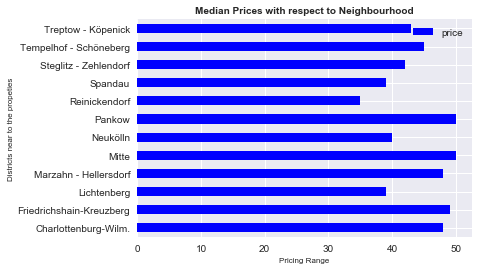

In [111]:
df_grouped_display = pd.DataFrame(new_dataframe.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped_display.reset_index(inplace=True)

# plot this 
df_grouped_display.plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(6,4), legend=True, color='blue')

plt.xlabel('Pricing Range', fontsize=8)
plt.ylabel('Districts near to the propeties', fontsize=8)
plt.title('Median Prices with respect to Neighbourhood', fontsize=10, fontweight='bold');

<h2> Price Difference By cancellation Policy</h2>

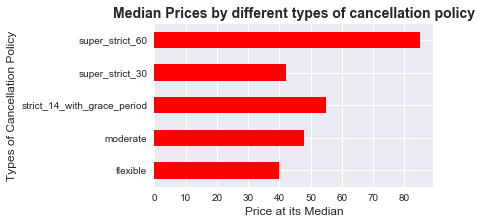

In [112]:
df_grouped = pd.DataFrame(new_dataframe.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(5,3), legend=False, color='red')

plt.xlabel('Price at its Median', fontsize=12)
plt.ylabel('Types of Cancellation Policy', fontsize=12)
plt.title('Median Prices by different types of cancellation policy', fontsize=14, fontweight='bold');

<h1> Data Modeling </h1>

In [90]:
new_dataframe.drop(['latitude', 'longitude', 'property_type','neighbourhood_group_cleansed'], axis=1, inplace=True)

In [91]:
for colname in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    new_dataframe[colname] = new_dataframe[colname].astype('category')

In [92]:
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18064 entries, 2015 to 29740105
Data columns (total 25 columns):
room_type                    18064 non-null category
host_has_profile_pic         18064 non-null category
minimum_nights               18064 non-null int64
is_business_travel_ready     18064 non-null category
bed_type                     18064 non-null category
amenities                    18064 non-null object
instant_bookable             18064 non-null category
cancellation_policy          18064 non-null category
review_scores_accuracy       18064 non-null float64
number_of_reviews            18064 non-null int64
accommodates                 18064 non-null int64
bathrooms                    18064 non-null float64
bedrooms                     18064 non-null float64
cleaning_fee                 18064 non-null float64
distance_from_center         18064 non-null float64
extra_people                 18064 non-null float64
guests_included              18064 non-null int64
pric

In [93]:
new_dataframe.head()

,room_type,host_has_profile_pic,minimum_nights,is_business_travel_ready,bed_type,amenities,instant_bookable,cancellation_policy,review_scores_accuracy,number_of_reviews,...,extra_people,guests_included,price,security_deposit,size_of_location,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed
2015,Entire home/apt,t,4,f,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",f,strict_14_with_grace_period,10.0,118,...,28.0,1,60.0,200.0,75.0,True,True,True,False,False
2695,Private room,t,2,f,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",f,flexible,10.0,6,...,0.0,1,17.0,0.0,25.0,True,False,False,False,False
3176,Entire home/apt,t,62,f,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",t,strict_14_with_grace_period,9.0,143,...,20.0,2,90.0,200.0,68.0,True,False,True,False,False
3309,Private room,t,5,f,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",f,strict_14_with_grace_period,9.0,25,...,18.0,1,26.0,250.0,26.0,True,False,False,True,False
7071,Private room,t,2,f,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",f,moderate,10.0,197,...,24.0,1,42.0,0.0,20.0,True,False,True,False,False


In [94]:
new_dataframe.drop(['amenities'], axis=1, inplace=True)

In [95]:
target_price = new_dataframe[["price"]]

all_features = new_dataframe.drop(["price"], axis=1)

In [96]:
numerical_features = all_features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
categorical_features = all_features.select_dtypes(include=['category']).copy()
categorical_features = pd.get_dummies(categorical_features)

In [97]:
final_features = pd.concat([numerical_features, categorical_features], axis=1)

In [98]:
print(final_features.shape)
final_features.head(2)

(18064, 35)


,minimum_nights,review_scores_accuracy,number_of_reviews,accommodates,bathrooms,bedrooms,cleaning_fee,distance_from_center,extra_people,guests_included,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,4,10.0,118,3,1.0,1.0,30.0,1.624949,28.0,1,...,0,0,1,1,0,0,0,1,0,0
2695,2,10.0,6,2,1.0,1.0,0.0,3.172058,0.0,1,...,0,0,1,1,0,1,0,0,0,0


In [99]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18064 entries, 2015 to 29740105
Data columns (total 35 columns):
minimum_nights                                     18064 non-null int64
review_scores_accuracy                             18064 non-null float64
number_of_reviews                                  18064 non-null int64
accommodates                                       18064 non-null int64
bathrooms                                          18064 non-null float64
bedrooms                                           18064 non-null float64
cleaning_fee                                       18064 non-null float64
distance_from_center                               18064 non-null float64
extra_people                                       18064 non-null float64
guests_included                                    18064 non-null int64
security_deposit                                   18064 non-null float64
size_of_location                                   18064 non-null float64
Lapto

<h1> Model Application </h1>

In [101]:
from sklearn.linear_model import LogisticRegression #loadingmodels from inbuilt libraries
import xgboost as xgb #importing xgboost from inbuilt library
from sklearn.tree import DecisionTreeRegressor #import decision tree regressor from sklearn
from sklearn.dummy import DummyRegressor #import dummy regressor from sklearn
from sklearn.neighbors import KNeighborsClassifier #import k neighbor classifier from sklearn
from sklearn.neighbors import KNeighborsRegressor #import k neighbor regressor from sklearn
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [102]:
from sklearn.model_selection import train_test_split#calling splitting function 
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(final_features, target_price, test_size=0.2) #Splitting features into test and train dataset

In [103]:
from sklearn.preprocessing import StandardScaler #importing scaler for normalizing the values
s_scaler = StandardScaler() #initializing the scalar
X_train_price = s_scaler.fit_transform(X_train_price) #scaling training dataset 
X_test_price= s_scaler.transform(X_test_price) #scaling testing dataset

In [98]:
knn= KNeighborsClassifier(n_neighbors=2)
def caculate_cross_val_scores_knn(X_test_price,y_test_price):
    scores=cross_val_score(knn, X_test_price,y_test_price, cv=10)
    scores_knn=[]
    for val in scores:
        scores_knn.append(val*10)
    return scores_knn

<h1> Decision Tree Regressor </h1>

In [99]:
d_tree = DecisionTreeRegressor()
# fit and train model
d_tree.fit(X_train_price, y_train_price)

value_pred_decisiontree = d_tree.predict(X_test_price)

In [100]:
d_tree.fit(X_train_price, y_train_price)
scores_dt=cross_val_score(d_tree, X_test_price,y_test_price, cv=10)

In [101]:
scores_dt

array([ 0.06483176,  0.21828012,  0.36585493,  0.25537717,  0.04142764,
        0.07318357,  0.3415167 , -0.10590635, -0.64958951,  0.33971206])

In [102]:
round(np.sqrt(mean_squared_error(y_test_price, value_pred_decisiontree)),4)

36.4669

In [103]:
r2_decision_tree = r2_score(y_test_price, value_pred_decisiontree)
r2_decision_tree

0.29307980110522125

<h1> XGBOOST </h1>

In [104]:
cv_booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

cv_booster.fit(X_train_price, y_train_price)
val_pred_booster = cv_booster.predict(X_test_price)
scores_bt=cross_val_score(cv_booster, X_test_price,y_test_price, cv=10)

[13:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [105]:
scores_bt

array([0.58877125, 0.58928778, 0.69180065, 0.6018771 , 0.67495533,
       0.61272769, 0.63913045, 0.59910248, 0.55536666, 0.63292803])

In [106]:
r2_booster = r2_score(y_test_price, val_pred_booster)
r2_booster

0.6637754801736346

In [107]:
round(np.sqrt(mean_squared_error(y_test_price, val_pred_booster)),4)

25.1495

<h1> Dummy Regressor </h1>

In [107]:
dr=DummyRegressor()
dr.fit(X_train_price,y_train_price)
val_pred_dr = dr.predict(X_test_price)
scores_dr=cross_val_score(dr,X_test_price,y_test_price,cv=10)
scores_dr

array([-3.34324120e-03, -2.54925417e-03, -6.57319609e-03, -5.35549197e-03,
       -4.64436335e-03, -8.05679293e-06, -2.96752573e-04, -5.51682684e-04,
       -2.87634367e-04, -1.84540613e-04])

In [108]:
round(np.sqrt(mean_squared_error(y_test_price, val_pred_dr)),4)

43.6231

In [109]:
r2_dummy_regr = r2_score(y_test_price, val_pred_dr)
r2_dummy_regr

-0.0007310427918874041

<h1> KNN </h1>

In [110]:
knn= KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_price,y_train_price)
val_pred_knn = knn.predict(X_test_price)
scores_knn=caculate_cross_val_scores_knn(X_test_price,y_test_price)
scores_knn

/home/ritika/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/ritika/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/ritika/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/ritika/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

[0.5496828752642706,
 0.5463182897862233,
 0.38461538461538464,
 0.7258064516129032,
 0.5898876404494382,
 0.471976401179941,
 0.547112462006079,
 0.53125,
 0.5844155844155844,
 0.8852459016393442]

In [111]:
round(np.sqrt(mean_squared_error(y_test_price, val_pred_knn)),4)

34.4288

In [112]:
r2_knn = r2_score(y_test_price, val_pred_knn)
r2_knn

0.3076275924468832

<h1> Linear Regression </h1>

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [114]:
lr=LinearRegression()
lr.fit(X_train_price,y_train_price)
val_pred_lr = lr.predict(X_test_price)
scores_lr=cross_val_score(lr, X_test_price,y_test_price, cv=10)
scores_lr

array([ 4.06207731e-01, -2.07405849e+00, -1.66154936e+21,  4.90596232e-01,
        4.60333316e-01,  4.74166000e-01,  4.72773816e-01,  5.51920784e-01,
        5.32252934e-01,  5.13184970e-01])

In [115]:
r2_lr = r2_score(y_test_price, val_pred_lr)
r2_lr

0.4129189628754012

In [116]:
round(np.sqrt(mean_squared_error(y_test_price, val_pred_lr)),4)

31.7031

<h1>Comparison of Models</h1>

<h2> Based on RMSE </h2>

In [117]:
rmse_values=[32.9263,22.9866,40.9853,33.8225,28.5357]

In [118]:
algo_names=['Decision Tree','xg_boost','dummy regressor','knn','Linear Regression']

In [119]:
def plot_bar__rmse():
    # this is for plotting purpose
    index = np.arange(len(algo_names))
    plt.bar(index,rmse_values)
    plt.xlabel('Name of algorithms', fontsize=10)
    plt.ylabel('Value of RMSE', fontsize=10)
    plt.xticks(index,algo_names, fontsize=10, rotation=30)
    plt.title('RMSE values for different algorithms')
    plt.show()

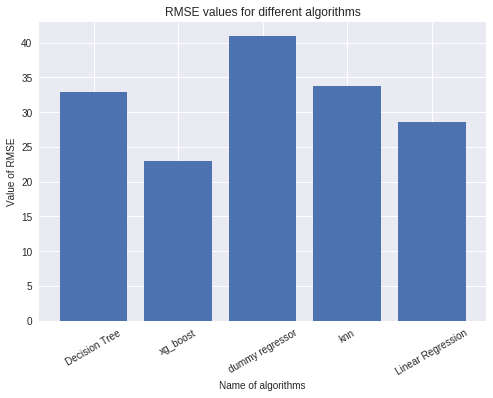

In [120]:
plot_bar__rmse()

<h2> Based on R2 Scores </h2>

In [121]:
r2_scores=[0.3541286104896251,0.6852168832966115,0.073104279,0.3184914339775635,0.51489172211404]

In [122]:
def plot_bar__r2scores():
    # this is for plotting purpose
    index = np.arange(len(algo_names))
    plt.bar(index,r2_scores)
    plt.xlabel('Name of algorithms', fontsize=10)
    plt.ylabel('Value of R2 Scores', fontsize=10)
    plt.xticks(index,algo_names, fontsize=10, rotation=30)
    plt.title('R2 Scores for different algorithms')
    plt.show()

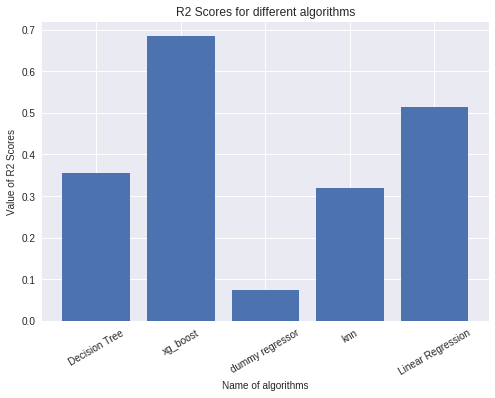

In [123]:
plot_bar__r2scores()

<h1> Statistical Testing</h1>

In [148]:
from scipy import stats

<h2> Comparing XG BOOST With other algorithms</h2>

In [149]:
stats.ttest_rel(scores_dr,scores_bt)

Ttest_relResult(statistic=-43.21583649594091, pvalue=9.496051870098077e-12)

In [150]:
stats.ttest_rel(scores_lr,scores_bt)

Ttest_relResult(statistic=-6.392477000256467, pvalue=0.0001263857540327622)

In [151]:
stats.ttest_rel(scores_knn,scores_bt)

Ttest_relResult(statistic=-5.155055762214709, pvalue=0.0005990542574018903)

In [152]:
stats.ttest_rel(scores_dt,scores_bt)

Ttest_relResult(statistic=-5.992890810472087, pvalue=0.00020427323091771072)

<h2> Comparing Dummy Regressor with other algorithms </h2>

In [153]:
stats.ttest_rel(scores_dr,scores_dt)

Ttest_relResult(statistic=-3.826685297578019, pvalue=0.004048226825923456)

In [154]:
stats.ttest_rel(scores_dr,scores_knn)

Ttest_relResult(statistic=-17.91953881096889, pvalue=2.3867618178334952e-08)

In [155]:
stats.ttest_rel(scores_dr,scores_lr)

Ttest_relResult(statistic=-21.956552759068646, pvalue=3.980402983162189e-09)

<h2> Comparing KNN with other algorithms </h2>

In [156]:
stats.ttest_rel(scores_knn,scores_lr)

Ttest_relResult(statistic=-0.9378222733321474, pvalue=0.3728189984052023)

In [157]:
stats.ttest_rel(scores_dr,scores_dt)

Ttest_relResult(statistic=-3.826685297578019, pvalue=0.004048226825923456)

<h2>Comparing Linear Regression with other algorithms </h2>

In [160]:
stats.ttest_rel(scores_lr,scores_dt)

Ttest_relResult(statistic=4.175518347330759, pvalue=0.002391942926034981)